<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using CUDA")
# else:
#     device = torch.device("cpu")
#     print("Using CPU")
device = torch.device("cpu")

In [4]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [9]:
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state_tensor)
        return torch.argmax(q_values, dim=1).item()


In [11]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(np.array(states)).to(device)
    actions = torch.LongTensor(np.array(actions)).to(device)
    rewards = torch.FloatTensor(np.array(rewards)).to(device)
    next_states = torch.FloatTensor(np.array(next_states)).to(device)
    dones = torch.FloatTensor(np.array(dones)).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [13]:
device = torch.device("cpu")
rewards_dqn = []
steps_to_goal = []
print(device)

for episode in range(num_episodes):
    state = env.reset()[0]
    total_reward = 0
    steps = 0
    done = False

    while not done and steps < 1000:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        total_reward += reward
        state = next_state
        steps += 1

        if steps % 50 == 0:
            print(f"  Step {steps}, reward so far: {total_reward}")

   
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)
    steps_to_goal.append(steps)


    if episode < 20 or (episode + 1) % 10 == 0:  
        avg_return = np.mean(rewards_dqn[-10:]) if len(rewards_dqn) >= 10 else np.mean(rewards_dqn)
        print(f"Episode {episode+1}/{num_episodes} | Steps: {steps} | Reward: {total_reward:.1f} | Avg: {avg_return:.1f} | ε: {epsilon:.3f}")

cpu
  Step 50, reward so far: -50.0
  Step 100, reward so far: -100.0
  Step 150, reward so far: -150.0
  Step 200, reward so far: -200.0
  Step 250, reward so far: -250.0
  Step 300, reward so far: -300.0
  Step 350, reward so far: -350.0
  Step 400, reward so far: -400.0
  Step 450, reward so far: -450.0
  Step 500, reward so far: -500.0
  Step 550, reward so far: -550.0
  Step 600, reward so far: -600.0
  Step 650, reward so far: -650.0
  Step 700, reward so far: -700.0
  Step 750, reward so far: -750.0
  Step 800, reward so far: -800.0
  Step 850, reward so far: -850.0
  Step 900, reward so far: -900.0
  Step 950, reward so far: -950.0
  Step 1000, reward so far: -1000.0
Episode 1/1000 | Steps: 1000 | Reward: -1000.0 | Avg: -1000.0 | ε: 0.214
  Step 500, reward so far: -500.0
  Step 550, reward so far: -550.0
  Step 600, reward so far: -600.0
  Step 650, reward so far: -650.0
  Step 700, reward so far: -700.0
  Step 750, reward so far: -750.0
  Step 800, reward so far: -800.0
  Ste

In [14]:
# Check your data first
print(f"Number of episodes completed: {len(rewards_dqn)}")
print(f"rewards_dqn contents: {rewards_dqn[:5] if len(rewards_dqn) > 0 else 'Empty'}")

Number of episodes completed: 1000
rewards_dqn contents: [-1000.0, -1000.0, -1000.0, -1000.0, -1000.0]


Used GPT to help plot

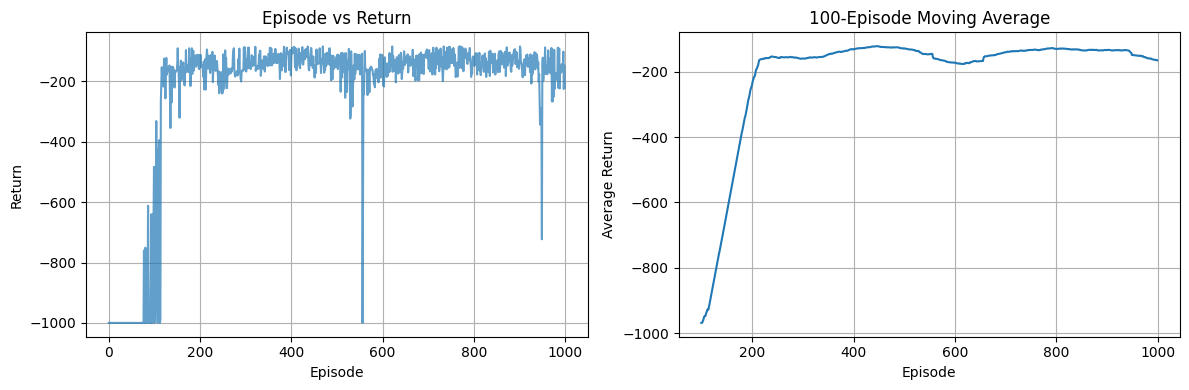

Final average return (last 100 episodes): -165.24
Final average steps (last 100 episodes): 165.2


In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards_dqn, alpha=0.7)
plt.title('Episode vs Return')
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid(True)

plt.subplot(1, 2, 2)

if len(rewards_dqn) >= 10:  
    window = min(100, len(rewards_dqn)//2)
    if window > 0:
        moving_avg = np.convolve(rewards_dqn, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rewards_dqn)), moving_avg)
        plt.title(f'{window}-Episode Moving Average')
    else:
        plt.plot(rewards_dqn)
        plt.title('Episode Returns (No Moving Average)')
else:
    plt.plot(rewards_dqn)
    plt.title('Episode Returns (Too Few Episodes for Moving Average)')

plt.xlabel('Episode')
plt.ylabel('Average Return')
plt.grid(True)

plt.tight_layout()
plt.show()


if len(rewards_dqn) >= 100:
    print(f"Final average return (last 100 episodes): {np.mean(rewards_dqn[-100:]):.2f}")
    print(f"Final average steps (last 100 episodes): {np.mean(steps_to_goal[-100:]):.1f}")
elif len(rewards_dqn) > 0:
    print(f"Average return (all {len(rewards_dqn)} episodes): {np.mean(rewards_dqn):.2f}")
    print(f"Average steps (all {len(steps_to_goal)} episodes): {np.mean(steps_to_goal):.1f}")
else:
    print("No episodes completed yet.")

Performance of your DQN agent: How quickly does it learn? Does it reach the goal consistently?
It learns very quick but stops learning a little after episode 200. Probably because of the step limit I needed to impose on it. So it doesn't learn consistantly throughout training


Which representation learns faster?
Tile coding learns faster in the begining because it updates neighborhoods and requires much lest calculation.

Which one is more stable?

Neural networks can be more stable because instead of updating neighborhoods in the input space it updates parameters in very complex functions.

How do the function approximation choices (linear with tiles vs. neural network) affect generalization?

Well tile coding generalizes uniformly and evenly in the input space and does not recognize dynamic behavior as well and just uses common distances.

Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
Yes it required much more tuning of epsilon and lr.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [ ]:
!pip uninstall -y box2d-py Box2D
!pip install box2d


In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import gymnasium as gym
!pip install gymnasium[box2d]



env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

alpha = 1e-3
gamma = 0.99
batch_size = 64
replay_buffer_size = 50000
num_episodes = 250
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class QNet(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)


    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


q_net = QNet(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)



def epsilon_greedy(state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()

    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)

    with torch.no_grad():
        q_values = q_net(state_tensor)

    return torch.argmax(q_values).item()


def train_dqn():
    if len(replay_buffer) < batch_size:
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1-dones)
    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


rewards_dqn = []

for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = epsilon_greedy(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.append((state, action, reward, next_state, done))
        train_dqn()
        state = next_state
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_dqn.append(total_reward)
    print(f"Episode {episode+1}/{num_episodes} | Return: {total_reward:.1f} | ε: {epsilon:.3f}")

env.close()